#All the imports we need

In [ ]:
import re
import nltk
import pandas as pd
import io
import pandas
import matplotlib.pyplot as plt
import numpy as np
!pip install textblob
nltk.download("popular")

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import files
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import tree

##Data load

First of all, we create a **Pandas DataFrame** from the original csv file. 

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving comments.csv to comments (3).csv
User uploaded file "comments.csv" with length 1691506 bytes


In [ ]:
comments = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

#Preprocessing

Once we have created the pandas dataframe, the first thing we do is a **preprocessing step**. It includes removing useless data, changing capital letters to lowercase letters, lemmatizing all terms to obtain the relevant information of each word with fewer characters, removing contractions as well as repeated words and emoticons followed by the last step, correcting wrong words. All of that is done to **supply clean input data** to the classification model.

So, let's begin **removing useless data** such as parenthesis, at signs, etc.

In [ ]:
comments["text"] = comments["text"].apply(lambda elem: re.sub('!',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('"',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('_',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('\$',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('%',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('&',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('/',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('\(',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('\)',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('=',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('\^',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('\*',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('¡',"",elem))
comments["text"] = comments["text"].apply(lambda elem: re.sub('@',"",elem))

We **remove all capital letters** changing them to lowercase letters

In [ ]:
comments["text"] = comments["text"].apply(lambda elem: elem.lower())

As we have mentioned, we **lemmatize all terms** with the purpose of obtaining the relevant information from the words.

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer=WordNetLemmatizer()

def lemmatizerAux(words):
  lemmatized_words = ""
  tokenized_words = word_tokenize(words)
  for word in tokenized_words:
    v_lemmatized_word = lemmatizer.lemmatize(word, pos = 'v')
    lemmatized_words = lemmatized_words + " " + lemmatizer.lemmatize(v_lemmatized_word, pos = 'n')
    #lemmatizer.lemmatize(word, pos = "v")
  return lemmatized_words

comments["text"] = comments["text"].apply(lambda elem: lemmatizerAux(elem))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Then, we **remove contractions** in order to standarize the words in the text taking into account the most usual ones in the English language.  

In [ ]:
patrones=[
('can t','cannot'),
('i m','i am'),
('i ll', 'i will'),
('you ll', 'you will'),
('they ll', 'they will'),
('isn t', 'is not'),
('don t', 'do not'),
('you ve', 'you have'),
('i ve', 'i have'),
('he s', 'he is'),
('she s', 'she is'),
('we re', 'we are'),
('they re', 'they are')
]

patrones = [(regex, no_contraido) for (regex, no_contraido) in patrones]

def remove_contractions(words):
  text = words
  for (patron, no_contraido) in patrones: 
    (s, count) = re.subn(patron, no_contraido, text)
    text = s
  return text

comments["text"] = comments["text"].apply(lambda elem: remove_contractions(elem))

We **remove repeated words** because they are not useful for the classification model.

In [ ]:
comments["text"] = comments["text"].apply(lambda elem: re.sub(r'\b(\w+)( \1\b)+', r'\1', elem))

We **remove emoticons** for the same reason as in the last step, they don´t provide any useful information for the classification model.

In [ ]:
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

def remove_emoji(text):
  return emoji_pattern.sub(r'', text)

comments["text"] = comments["text"].apply(lambda elem: remove_emoji(elem))

Eventually, we **correct wrong words** using **TextBlob**

In [ ]:
def correct_words(text):
  new_doc = TextBlob(text)
  result = new_doc.correct()
  return str(result)

comments["text"] = comments["text"].apply(lambda elem: correct_words(elem))

We save the results as a **pickle file**.

In [ ]:
comments.to_pickle('./preprocessed.pkl')

#Vectorization

We **read the pickle file** that we have saved

In [ ]:
comments = pd.read_pickle('./preprocessed.pkl')

We convert **"class" feature into a numerical feature** in order to use it in the **Decision Tree algorithm**

In [ ]:
numerical_values = []
for i in range(len(comments)):
  if(comments["class"].values[i] == "Auto"):
    numerical_values.append(0)
  elif(comments["class"].values[i] == "Camera"):
    numerical_values.append(1)

data = {'class':numerical_values}
numerical_class = pd.DataFrame(data=data)

We define a function to **calculate several evaluation metrics** for the support vector machine model

In [ ]:
def calculate_metrics(tp, fp, tn, fn):
    precision= tp/ (tp + fp)
    recall= tp/ (tp+fn)
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    f_measure= 2*(recall * precision) / (recall + precision)
    print("Precision "+ str(precision) +"\nRecall " + str(recall) + "\nAccuracy " + str(accuracy) + "\nF-Measure " + str(f_measure))

##TFIDF

We calculate the vectorization of the text by using a standard **TFIDF vectorizer**. It returns the **relevance of each word** taking into account the document in which each word appears and the rest of the documents in the collection.

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
output_tfidf = vectorizer.fit_transform(comments["text"].tolist())

df_output_tfidf=pandas.DataFrame(output_tfidf.toarray(), columns=vectorizer.get_feature_names())
df_output_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,01,02,024,03,03cm,04,048,05,050,06,07,07280001,075,08,09,0f,0l,0litre,0m,0x,10,100,1000,1000f,1000fn,1000ma,1000mb,1000th,100cs,100k,100lbs,100mph,100s,102,1024,1024x768,102769987204,102mm,...,youth,youthful,yr,yrs,yugo,yup,yuppies,z1,z3,z3m,z66,z71,zagging,zdnet,zealand,zeiss,zero,zeroed,ziebart,zig,zillions,zing,zip,zipp,zippier,zippiness,zippy,zips,zj,zone,zones,zoo,zoom,zoombrowser,zoomed,zoomey,zooming,zooms,zx2,zx3
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062768,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.065004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Feature selection of TF-IDF output

We execute the **SelectKBest** algorithm to get the **most relevant features** of the **output of the TDIDF vectorizer**


In [ ]:
selector = SelectKBest(score_func=chi2,k=round((df_output_tfidf.shape[1] * 30)/100))
output_tfidf_new = selector.fit_transform(df_output_tfidf, comments["class"])

We convert the results to a **dataframe** in order to get a **valid input** data for the **classification model**.

In [ ]:
selected_indexes = selector.get_support()
selected_columns = []
column_names = df_output_tfidf.columns
dataframes = []
for i in range(df_output_tfidf.shape[1]):
  if selected_indexes[i] == True:
    aux = []
    aux.append(df_output_tfidf.iloc[:,i].tolist())

    dataframes.append(pd.DataFrame(aux, [column_names[i]]).transpose())

selected_features = pd.concat(dataframes, axis=1)

We saved it as a **pickle file**

In [ ]:
selected_features.to_pickle('./selected_features_task2.pkl')

##SVM for TF-IDF output

We divide the dataset into a percentage of **70 for the training** and **30 for the test**, as we have decided to divide it in this way, so the algorithm has more training and will give us good results in the test.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features, comments["class"], test_size=0.3, shuffle=True)

We **execute** the **Support Vector Machine.**

In [ ]:
SVM = svm.SVC(kernel='linear', gamma='auto') # SVM Model Definition
SVM.fit(X_train,y_train) # Training the model

result = SVM.predict(X_test)

We calculate **evaluation metrics** returning the true negatives, false positives, false negatives and true positives.

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, result).ravel()

calculate_metrics(tp, fp, tn, fn)

Precision 1.0
Recall 1.0
Accuracy 1.0
F-Measure 1.0


We **visualize the confusion matrix** with the metrics obtained in SVM.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


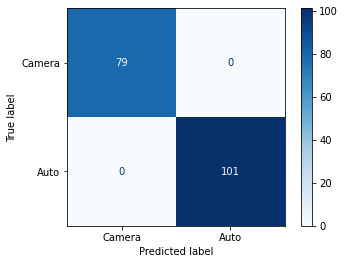

[[ 79   0]
 [  0 101]]


In [ ]:
#SVM ya debe estar entrenado
disp = plot_confusion_matrix(SVM, X_test, y_test, display_labels=["Camera", "Auto"],cmap=plt.cm.Blues) 
plt.show()
print(disp.confusion_matrix)

As we have seen, there are **79 true positives of camera class** and **101 true positives of auto class**.

##Decision tree for TF-IDF output

In [ ]:
selected_features = pd.read_pickle('./selected_features_task2.pkl')

We divide the data into **70% of train and 30% of test**.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features, numerical_class, test_size=0.3, shuffle=True)

We try the **DecissionTreeRegresor** with a **max_depth** value from **1 to 30.**

No handles with labels found to put in legend.


Min Value : 0.009523809523809523 (3)


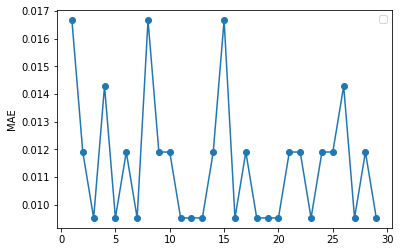

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)
total_scores = []
for i in range(1,30):
       fold_mae = []
       regr = tree.DecisionTreeRegressor(max_depth=i)
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          regr.fit(fx_train, fy_train)
          y_pred = regr.predict(fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
      
      
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
plt.legend()
plt.show() 

We execute the **DecisionTreeRegressor** with a **max_depth** value of **4**

In [ ]:
regr = tree.DecisionTreeRegressor(max_depth = 4)
regr.fit(fx_train, fy_train)

DecisionTreeRegressor(max_depth=4)

In [ ]:
y_pred = regr.predict(X_test)

We **visualize the results**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


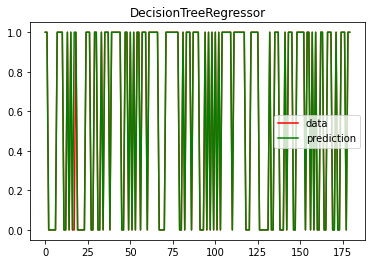

In [ ]:
# x axis for plotting
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor")

plt.show()

##TFIDF + N-GRAM



We calculate the vectorization of the text by using a standard **TFIDF vectorizer** and a **ngram_range** from **1 to 3**. It returns the **relevance of each 1 to 3 word combinations** keeping in mind the document each combination appears and the rest of the documents in the collection.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
output_tfidf_ngram = vectorizer.fit_transform(comments["text"].tolist())

df_output_tfidf_ngram=pandas.DataFrame(output_tfidf_ngram.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Feature selection of TF-IDF + N-GRAM output

We execute the **SelectKBest** algorithm to get the **most relevant features** of the **output of the TDIDF vectorizer with the 1 to 3 ngrams**

In [ ]:
selector = SelectKBest(score_func=chi2,k=round((df_output_tfidf_ngram.shape[1] * 30)/100))
output_tfidf_ngram_new = selector.fit_transform(df_output_tfidf_ngram, comments["class"])

We convert the results to a **dataframe** in order to get a **valid input** data for the **classification model**.

In [ ]:
selected_features_ngram = pd.DataFrame(output_tfidf_ngram_new)

##SVM for TFIDF + N-GRAM output

We divide the dataset into a percentage of **70 for the training** and **30 for the test** again

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features_ngram, comments["class"], test_size=0.3, shuffle=True)

We **execute** the **Support Vector Machine**

In [ ]:
SVM = svm.SVC(kernel='linear', gamma='auto') # SVM Model Definition
SVM.fit(X_train,y_train) # Training the model

result = SVM.predict(X_test)

We calculate **evaluation metrics** returning the true negatives, false positives, false negatives and true positives.

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, result).ravel()

calculate_metrics(tp, fp, tn, fn)

Precision 1.0
Recall 1.0
Accuracy 1.0
F-Measure 1.0


We **visualize the confusion matrix** with the metrics obtained in SVM.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


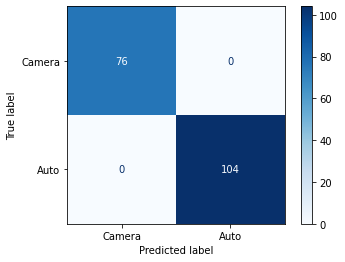

[[ 76   0]
 [  0 104]]


In [ ]:
disp = plot_confusion_matrix(SVM, X_test, y_test, display_labels=["Camera", "Auto"],cmap=plt.cm.Blues) 
plt.show()
print(disp.confusion_matrix)

As we have seen, there are **76 true positives of camera class** and **104 true positives of auto class**.

##Decision tree for TFIDF + N-GRAM output

We divide the data into **70% of train and 30% of test** again.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features_ngram, numerical_class, test_size=0.3, shuffle=True)

We try the **DecissionTreeRegresor** with a **max_depth** value from **1 to 5.**

No handles with labels found to put in legend.


Min Value : 0.011904761904761904 (2)


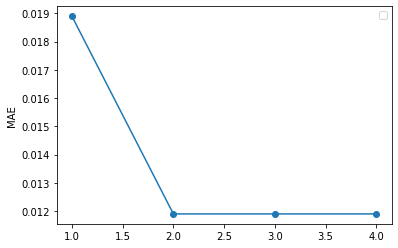

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)
total_scores = []
for i in range(1,5):
       fold_mae = []
       regr = tree.DecisionTreeRegressor(max_depth=i)
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          regr.fit(fx_train, fy_train)
          y_pred = regr.predict(fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
      
      
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
plt.legend()
plt.show() 

We execute the **DecisionTreeRegressor** with a **max_depth** value of **2**

In [ ]:
regr = tree.DecisionTreeRegressor(max_depth = 2)
regr.fit(fx_train, fy_train)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y_pred = regr.predict(X_test)

We **visualize the results**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


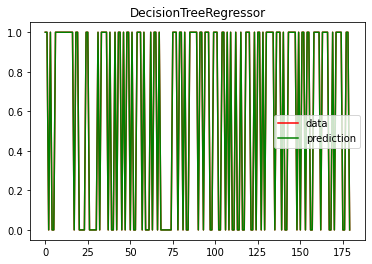

In [ ]:
# x axis for plotting
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor")

plt.show()

##TFIDF + N-GRAM + POS TAGGING

###POS tagging

We define a function to **calculate** the **POS tags of each document.** Then, we **include** the pos tags per document **as a column in the dataframe**.

In [ ]:
pos_tagging_column = []

def pos_tagging(text):
  tags = ""
  tokens  = word_tokenize(text)
  pos_tags = nltk.pos_tag(tokens)
  for tag in pos_tags:
    tags = tags + tag[1] + " "
  return tags

for i in range(len(comments)):
  pos_tagging_column.append(pos_tagging(comments.loc[i, "text"]))
comments["POS"] = pos_tagging_column

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Now, a function to create a **column per type of POS tagging** taking into account **each document** is defined.


In [ ]:
#Tipos de pos_tagging
types = ["NNS", "VBP", "RB", "VB", "DT", "NN", "IN", "JJ", "WDT", "VBN", "CC", "JJR", "PRP", "VBZ", "WP", "TO", "RB", "PRP$", "CD", "WRB", "MD", "NNP", "JJR", "PDT"]
pos_column = []

def calculate_number_pos_tag(post_tag, document_pos_taggings):
    count = 0
    tokens  = word_tokenize(document_pos_taggings)
    for token in tokens:
      if(token == post_tag):
        count= count + 1
    return count
table = []
#Recorremos los tipos
for type in types:
  #Para cada documento contamos los pos_taggings de ese tipo
  for document_pos_taggings in comments['POS']:
    counter = calculate_number_pos_tag(type, document_pos_taggings )
    pos_column.append(str(counter))
  table.append(pos_column) 
  pos_column = []

The **results** are **converted** into a **dataframe**

In [ ]:
df = pd.DataFrame(table)
df= df.transpose()
df.columns = types
df

,NNS,VBP,RB,VB,DT,NN,IN,JJ,WDT,VBN,CC,JJR,PRP,VBZ,WP,TO,RB,PRP$,CD,WRB,MD,NNP,JJR,PDT
0,2,12,15,17,24,63,24,25,3,4,11,1,7,1,2,5,15,0,1,1,0,0,1,1
1,5,32,17,46,57,137,64,50,5,2,21,2,45,3,2,13,17,0,7,4,13,1,2,0
2,3,13,21,21,37,77,24,26,2,3,6,1,10,4,0,13,21,0,7,1,4,0,1,1
3,3,12,16,22,23,40,21,20,0,1,6,0,12,9,1,5,16,0,3,1,3,0,0,0
4,12,32,48,56,112,287,104,108,8,5,40,11,36,16,5,18,48,0,42,3,5,0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,4,17,27,47,54,86,41,42,0,3,11,2,31,2,0,14,27,0,8,0,6,0,2,1
596,3,26,25,31,39,78,37,24,2,0,17,1,22,5,0,10,25,0,7,1,2,0,1,2
597,3,3,14,27,12,30,14,11,1,1,8,0,14,0,1,5,14,0,0,0,4,0,0,0
598,3,20,30,47,48,112,50,40,5,10,22,4,25,0,1,10,30,0,17,3,6,0,4,0


The **dataframe** obtained with TFIDF vectorizer + ngrams is concatenated with the **most relevant features that we have consider in the POS tagging based on the number of occurencies**. This features are: **NN** (nouns), **VB** (verbs), **JJ** (adjetives) and **RB** (adverbs).

In [ ]:
tfidf_ngram_pos = pd.concat([df_output_tfidf_ngram, df['NN'], df['VB'], df['JJ'], df['RB']], axis=1)

We save the results as a **pickle file**

In [ ]:
tfidf_ngram_pos.to_pickle('./tfidf_ngram_pos.pkl')

##Feature selection of TF-IDF + N-GRAM + POS Tagging output



In [ ]:
tfidf_ngram_pos = pd.read_pickle('./tfidf_ngram_pos.pkl')

We execute the **SelectKBest** algorithm to get the **most relevant features** of the **output of the TDIDF vectorizer with the one to three ngrams + POS tagging**

In [ ]:
selector = SelectKBest(score_func=chi2,k=round((tfidf_ngram_pos.shape[1] * 30)/100))
output_tfidf_ngram_pos_new = selector.fit_transform(tfidf_ngram_pos, comments["class"])

We convert the results to a **dataframe** in order to get a **valid input** data for the **classification model**.

In [ ]:
selected_features_ngram_pos = pd.DataFrame(output_tfidf_ngram_pos_new)

We save the results as a **pickle file**

In [ ]:
selected_features_ngram_pos.to_pickle('./selected_features_ngram_pos.pkl')

##SVM for TFIDF + N-GRAM + POS Tagging output

We divide the dataset into a percentage of **70 for the training** and **30 for the test** again.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features_ngram_pos, comments["class"], test_size=0.3, shuffle=True)

We **execute** the **Support Vector Machine**.

In [ ]:
SVM = svm.SVC(kernel='linear', gamma='auto') # SVM Model Definition
SVM.fit(X_train,y_train) # Training the model

result = SVM.predict(X_test)

We calculate **evaluation metrics** returning the true negatives, false positives, false negatives and true positives.

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, result).ravel()

calculate_metrics(tp, fp, tn, fn)

Precision 1.0
Recall 1.0
Accuracy 1.0
F-Measure 1.0


We **visualize the confusion matrix** with the metrics obtained in SVM.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


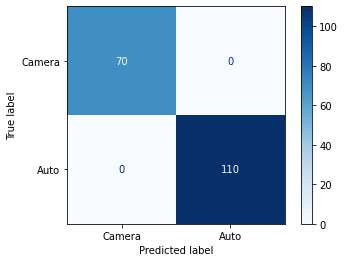

[[ 70   0]
 [  0 110]]


In [ ]:
disp = plot_confusion_matrix(SVM, X_test, y_test, display_labels=["Camera", "Auto"],cmap=plt.cm.Blues) 
plt.show()
print(disp.confusion_matrix)

As we have seen, there are **70 true positives of camera class** and **110 true positives of auto class**.

##Decision tree for TFIDF + N-GRAM + POS Tagging output

In [ ]:
selected_features_ngram_pos = pd.read_pickle('./selected_features_ngram_pos.pkl')

We divide the data into **70% of train and 30% of test** again.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(selected_features_ngram_pos, numerical_class, test_size=0.3, shuffle=True)

We try the **DecissionTreeRegresor** with a **max_depth** value from **1 to 5.**

No handles with labels found to put in legend.


Min Value : 0.011904761904761904 (2)


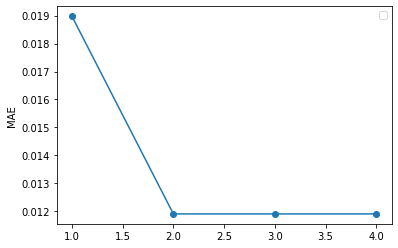

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)
total_scores = []
for i in range(1,5):
       fold_mae = []
       regr = tree.DecisionTreeRegressor(max_depth=i)
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          regr.fit(fx_train, fy_train)
          y_pred = regr.predict(fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
      
      
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
plt.legend()
plt.show()

We execute the **DecisionTreeRegressor** with a **max_depth** value of **2**

In [ ]:
regr = tree.DecisionTreeRegressor(max_depth = 2)
regr.fit(fx_train, fy_train)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y_pred = regr.predict(X_test)

We **visualize the results**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


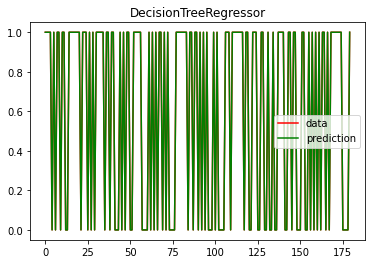

In [ ]:
# x axis for plotting
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor")

plt.show()

##TFIDF + N-GRAMS + POS TAGGING + NUMBER OF WORDS

We define a function to **calculate** the **number of words in each text**. Then, we **include** them **as a column in the dataframe**.

In [ ]:
def number_of_words(text):
  tokens = nltk.word_tokenize(text)
  return str(len(tokens))

number_of_words_column = []

for i in range(len(comments)):
  number_of_words_column.append(number_of_words(comments.loc[i, "text"]))

comments["number_of_words"] = number_of_words_column

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

The **dataframe** obtained with TFIDF vectorizer + ngrams + POS tags is concatenated with the previous one with the **number of words per text**.

In [ ]:
tfidf_ngram_pos_numberOfWords = pd.concat([tfidf_ngram_pos, comments["number_of_words"]], axis=1)

We save the results as a **pickle file**

In [ ]:
tfidf_ngram_pos_numberOfWords.to_pickle('./tfidf_ngram_pos_numberOfWords.pkl')

##Feature selection of TF-IDF + N-GRAM + POS Tagging + Number of words output

In [ ]:
tfidf_ngram_pos_numberOfWords = pd.read_pickle('./tfidf_ngram_pos_numberOfWords.pkl')

We execute the **SelectKBest** algorithm to get the **most relevant features** of the **output of the TDIDF vectorizer with the 1 to 3 ngrams + POS tagging + number of words**

In [ ]:
selector = SelectKBest(score_func=chi2,k=round((tfidf_ngram_pos_numberOfWords.shape[1] * 30)/100))
output_tfidf_ngram_pos_numberOfWords_new = selector.fit_transform(tfidf_ngram_pos_numberOfWords, comments["class"])

We convert the results to a **dataframe** in order to get a **valid input** data for the **classification model**.

In [ ]:
df_output_tfidf_ngram_pos_new = pd.DataFrame(output_tfidf_ngram_pos_numberOfWords_new)

We **save** the results as a **pickle file**

In [ ]:
df_output_tfidf_ngram_pos_new.to_pickle('./df_output_tfidf_ngram_pos_new.pkl')

##SVM for TFIDF + N-GRAM + POS Tagging + Number of words output

We divide the dataset into a percentage of **70 for the training** and **30 for the test** again.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_output_tfidf_ngram_pos_new, comments["class"], test_size=0.3, shuffle=True)

We **execute** the **Support Vector Machine**

In [ ]:
SVM = svm.SVC(kernel='linear', gamma='auto') # SVM Model Definition
SVM.fit(X_train,y_train) # Training the model

result = SVM.predict(X_test)

We calculate **evaluation metrics** returning the true negatives, false positives, false negatives and true positives.

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, result).ravel()

calculate_metrics(tp, fp, tn, fn)

Precision 1.0
Recall 1.0
Accuracy 1.0
F-Measure 1.0


We **visualize the confusion matrix** with the metrics obtained in SVM.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


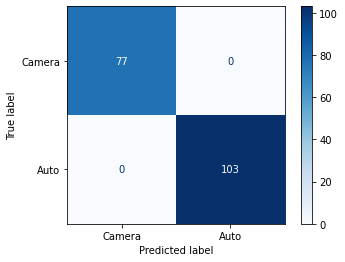

[[ 77   0]
 [  0 103]]


In [ ]:
disp = plot_confusion_matrix(SVM, X_test, y_test, display_labels=["Camera", "Auto"],cmap=plt.cm.Blues) 
plt.show()
print(disp.confusion_matrix)

As we have seen, there are **77 true positives of camera class** and **103 true positives of auto class**.

##Decision tree for TFIDF + N-GRAM + POS Tagging + Number of words output

We divide the data into **70% of train and 30% of test** again.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_output_tfidf_ngram_pos_new, numerical_class, test_size=0.3, shuffle=True)

We try the **DecissionTreeRegresor** with a **max_depth** value from **1 to 5.**

No handles with labels found to put in legend.


Min Value : 0.0047619047619047615 (2)


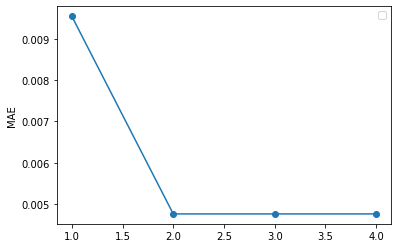

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)
total_scores = []
for i in range(1,5):
       fold_mae = []
       regr = tree.DecisionTreeRegressor(max_depth=i)
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          regr.fit(fx_train, fy_train)
          y_pred = regr.predict(fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
      
      
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
plt.legend()
plt.show()

We execute the **DecisionTreeRegressor** with a **max_depth** value of **2**

In [ ]:
regr = tree.DecisionTreeRegressor(max_depth = 2)
regr.fit(fx_train, fy_train)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y_pred = regr.predict(X_test)

We **visualize the results**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


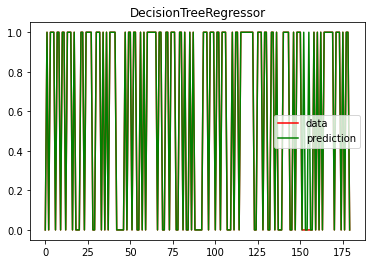

In [ ]:
# x axis for plotting
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor")

plt.show()

#Conclusions

As we have seen in this task, not only **numerical features** are useful in order to develop a classification model. **Text-based features** can **contribute** notably to this process. However, to use this kind of features, a **preprocess step** needs to be done because text may content useless information, misspelled words, etc. Furthermore, we have to use a **TF-IDF vectorizer** to ensure a **valid input** for the classification model. In addition, there are some interesting tools such as **n-grams** because we have checked that we can obtain really useful word combinations and **POS tags** because they allow us to focus on different types of words depending on our aim.